# Automatic Color Enhancement (ACE)

*Louis Martinez*

[Link to the paper](./References/ace.pdf)

$$R(x)=\sum_{y\in \Omega| x}\frac{S_\alpha(I(x)-I(y))}{\|x-y\|}, x \in \Omega$$

$$L(x)=\frac{R(x)-min R}{max R - min R}$$

$$S_\alpha(t) = min\{max\{\alpha t, -1\}, 1\}$$

We consider that the input image $I$ has shape $(N,N,3)$. (3 for RGB channels)  
Formally speaking, am image is defined as follows :
$$I :x\in\Omega=[\![0,N-1]\!]^2\mapsto[0,1]$$

In [1]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
from tqdm import tqdm
from multiprocess import Pool
import numpy as np
from numpy.fft import fft2, ifft2
import scipy
from scipy.special import binom

---
## Naive implementation $O(N^4)$

The direct computation of $R(x)$ is expensive as it requires $N^4$ operations.  
For each pixel in the image, we need to iterate over all the pixels to compute the value of $R(x)$.

In [2]:
# %%writefile ACE.py
# import numpy as np

def S_a(t: float, alpha=5) -> float:
    """
    Computes the value S_alpha(t) as defined above

    Parameters
    ------
    t: float
        Input value

    alpha: uint, optional
        Value of the slope of function S_a

    Returns
    ------
    S_a(x): float
    """
    return np.minimum(np.maximum(alpha * x, -1),1)

def R(I: np.ndarray, N: int, x: tuple) -> float:
    """
    Computes R(x)
    Only works for square gray-level images

    I: image shape(N,N,1)
    N: shape of the image
    x: coordinates of the pixel to compute R
    """
    assert I.shape[0] == I.shape[1] == N
    res = 0
    x_array = np.array(x)
    for i in range(N):
        for j in range(N):
            y = (i,j)
            if y != x:
                y_array = np.array(y)
                dist = np.linalg.norm(x_array - y_array)
                s = S_a(I[x] - I[y])
                res += s/dist
    return res
            
def L(R_vals: np.ndarray) -> np.ndarray:
    """
    Computes L for all R values as defined above.
    Takes a 2D np array as input, corresponding to the R-values of each pixel
    """
    minR = R_vals.min()
    maxR = R_vals.max()
    return (R_vals - minR) / (maxR - minR)

def compute_R_vals(I: np.ndarray) -> np.ndarray:
    """
    Compute R-values for a whole image.
    Works only for square gray-level images

    I: source image
    """
    assert I.shape[0] == I.shape[1]
    N = I.shape[0]
    R_vals = np.zeros((N,)*2)
    for i in range(N):
        for j in range(N):
            x = (i,j)
            R_vals[x] = R(I, N, x)
    return R_vals

def ACE(I: np.ndarray) -> np.ndarray:
    """
    Applies ACE to image I.
    I must be a square gray-level image

    I: source image
    """
    R_vals = compute_R_vals(I)
    return L(R_vals)

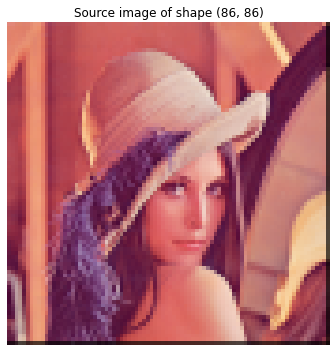

In [3]:
# initialize and normaliwe image
im = imread('images/lena-rgb.png') / 255.0
# downscale for faster computation
im_ds = downscale_local_mean(im, (6,6,1))

plt.figure(figsize=(5,5))
plt.imshow(im_ds)
plt.title(f'Source image of shape {im_ds.shape[:2]}')
plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
from ACE import ACE

I = im_ds

im_channels = [I[:,:,i] for i in range(I.shape[2])] # rgb channels
# execute ACE on each channel in parallel for faster computation
with Pool(len(im_channels)) as p:
    outputs = list(tqdm(p.imap(ACE, im_channels), total=len(im_channels)))
im_ace = np.stack(arrays=outputs, axis=2)

100%|██████████| 3/3 [11:10<00:00, 223.34s/it]


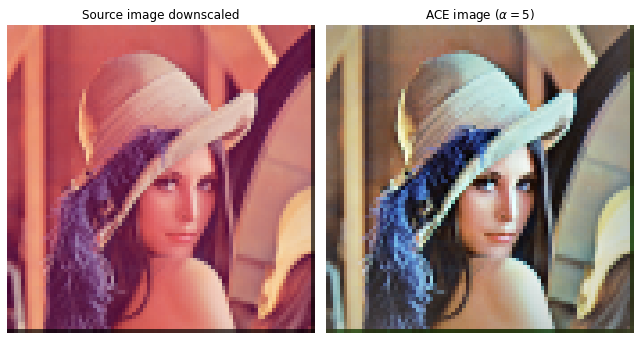

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].imshow(im_ds)
ax[0].set_title('Source image downscaled')
ax[0].axis('off')
ax[1].imshow(im_ace)
ax[1].set_title(r'ACE image ($\alpha=5$)')
ax[1].axis('off')
plt.tight_layout()
plt.show()

---
## Approximate methods $O(N^2log(N))$

$S_\alpha$ is now approximated by a polynomial. Thanks to this approximation, the computation of $R(x)$ can be rewrited as a convolution, which is faster to compute thanks to FFT or DCT.  
As suggested by the article, the polynomial is determined using Remez algorithm.   
The algorithm is initialized with Chebychev nodes on interval $[-1,1]$.

Chebychev nodes on interval $[a,b]$ for polynomial interpolant of degree $n$ :

$$x_i=\frac{1}{2}(a+b)+\frac{1}{2}(b-a)cos\left(\frac{2i-1}{2n}\pi\right)\hspace{30pt} i=1,...,n$$

In [6]:
def chebytchev_nodes(n: int, a=-1, b=1) -> np.ndarray:
    """
    Computes chebychev of a polynomial of degree n on interval [a,b]
    """
    return np.array([0.5 * (a+b) + 0.5 * (b-a) * np.cos(np.pi * (2*i-1) / (2*n)) for i in range(1, n+1)])

def bisection_search(F: callable, low: float, high:float, tol=1e-10) -> float:
    """
    Performs a bisection search of function F on interval [low,high]
    """
    if F(high) < F(low):
        low, high = high, low
    mid = 0.5 * (low + high)
    
    while abs(high - low) > tol:
        if F(mid) < 0:
            low = mid
        else:
            high = mid
        mid = 0.5 * (high + low)
    return mid

def find_extremum(F: callable, low:float, high:float, tol=1e-5) -> float:
    """
    Determines the extremum of F on interval [low, high] using an approximation of the derivative of F.
    Once the approximate derivative of F is determied, it performs a bisection search to find the zero of the derivative
    """
    scale = abs(high - low)
    h = tol * scale
    dF = lambda x: (F(x + h) - F(x - h)) / (2*h)

    return bisection_search(dF, low, high)

def remez(F: callable, n: int, max_iter=100, stop_tol=1.001) -> tuple:
    """
    Performs Remez algorithm to determine the coefficients of the approximate polynomial of F
    """
    init_points = chebytchev_nodes(n+2)
    A = np.zeros((n+2,)*2)
    b = np.zeros(n+2)
    coefs = np.zeros(n+2)
    
    E = np.array([(-1)**(i+1) for i in range(n+2)])
    A[:,n+1] = E

    for i in range(max_iter):
        for i in range(n+1):
            A[:,i] = init_points**i
            b[i] = F(init_points[i])
        b[-1] = F(init_points[-1])

        params = scipy.linalg.solve(A, b)
        coefs = np.flip(params[:-1]) # remove E (alternating criterion)
        
        residual = lambda x : F(x) - np.polyval(coefs, x)

        # FIND THE ROOTS OF ERROR FUNCTION
        roots_intervals = [[init_points[i], init_points[i+1]] for i in range(n+1)] # N+1 intervals
        roots = [1] + [bisection_search(residual, interval[0], interval[1]) for interval in roots_intervals] + [-1]
        
        # FIND THE EXTREMA IN INTERVALS BETWEEN EACH ROOT
        extrema_intervals = [[roots[i], roots[i+1]] for i in range(n+2)] # N+2 intervals
        extrema = [find_extremum(residual, interval[0], interval[1]) for interval in extrema_intervals]
        extrema[0] = 1
        
        init_points = np.array(extrema)

        # STOPPING CRITERION
        errors = np.abs(residual(init_points))
        if 1 <= errors.max()/errors.min() <= stop_tol:
            break
        else:
            extrema[-1] = -1  
            

    return coefs, residual, init_points

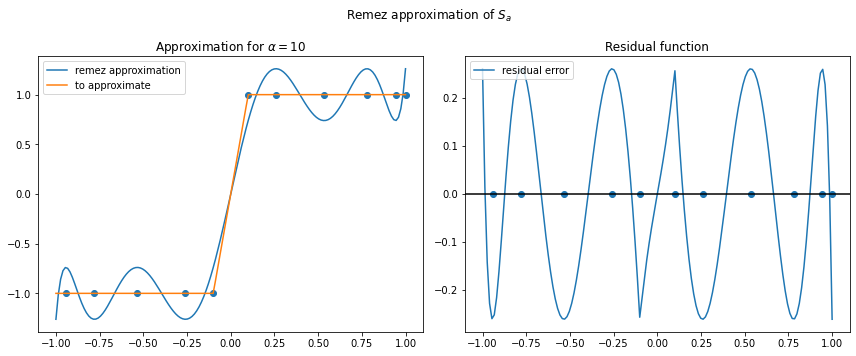

In [22]:
degree = 9
alpha = 10
F = lambda x : S_a(x, alpha)

coefs, residual, points = remez(F, degree, max_iter=10)
coefs[np.abs(coefs)<1e-3] = 0

x = np.linspace(-1, 1, 150)
y = np.polyval(coefs, x)
z = F(x)
err = residual(x)


fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(x, y, label='remez approximation')
ax[0].plot(x, z, label='to approximate')
ax[0].scatter(points, F(points))
ax[0].set_title(rf'Approximation for $\alpha=${alpha}')
ax[0].legend()

ax[1].plot(x, err, label='residual error')
ax[1].scatter(points, [0 for i in range(len(points))])
ax[1].axhline(y=0, color='k')
ax[1].set_title(f'Residual function')
ax[1].legend()
plt.suptitle(rf'Remez approximation of $S_a$')
plt.tight_layout()
plt.show()

In [8]:
coefs

array([ 2.86726220e+01,  2.50134138e+00, -7.33636148e+01, -4.98221428e+00,
        6.71314350e+01,  3.25821806e+00, -2.68871560e+01, -7.83077702e-01,
        5.47268062e+00,  5.30957977e-02])

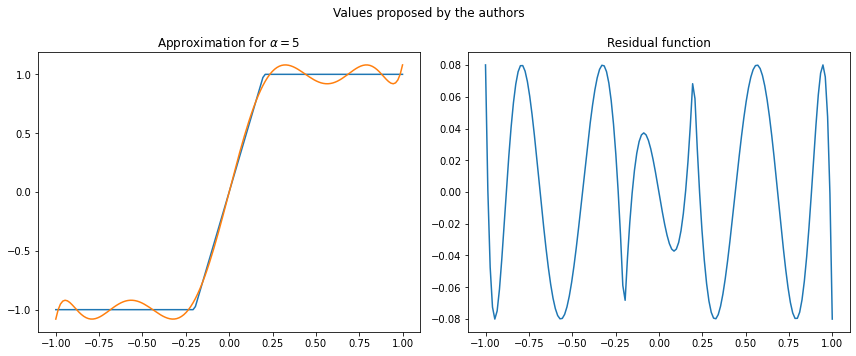

In [9]:
ref_alpha = 5
ref_F = lambda x: S_a(x, ref_alpha)
ref_coefs = {
    5: [0, 5.64305564, 0, -28.94026159, 0, 74.52401661, 0, -83.54012582, 0, 33.39343065]
}

ref_residual = lambda x : ref_F(x) - np.polyval(np.flip(ref_coefs[5]), x)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(x, ref_F(x))
ax[0].plot(x, np.polyval(np.flip(ref_coefs[5]), x))
ax[0].set_title(rf'Approximation for $\alpha=${ref_alpha}')
ax[1].plot(x, ref_residual(x))
ax[1].set_title('Residual function')
plt.suptitle('Values proposed by the authors')
plt.tight_layout()
plt.show()

---
## Fast computation using polynomial approximation

Convolutions are computed with FFT (DCT could work)

**From now we assume that the image is a square of size $N\times N$**

$$R(x)=\sum_{n=0}^M a_n(x)(\omega\ast I^n)(x)$$

$$\mathbb{T}^2=\{(x_1,x_2) \in \{0,1,2,...,2N-1\}^2\}$$

with :  
$s_\alpha(t)\simeq \sum_{m=1}^M c_mt^m$  
$a_n(x)=\sum_{m=n}^M c_n \binom{m}{n} (-1)^{m-n+1}I(x)^{m-n}$  
$(\omega\ast I^n)(x)=\sum_{y\in\mathbb{T}^2}\omega (y-x)I(y)^n=\sum_{y\in\mathbb{T}^2}\frac{1}{d(y-x)}I(y)^n$

where $M$ is the degree of the approximation polynomial.  
$(\omega\ast I^n)(x)$ is computed with FFT : $(\omega\ast I^n)(x)=\mathcal{F}^{-1}(\mathcal{F}(\omega).\mathcal{F} (I^n))(x)$

In [10]:
def compute_sum_terms(I: np.ndarray, N:int, n: int, coefs: np.ndarray, degree: int) -> np.ndarray:
    """
    Computes a_n as defined above
    
    Parameters
    ------
    I: ndarray
        Input image
    
    N: uint
        Width and height of I (assumed to be a square)
    
    n: uint
        Index in interval [0,M] where M is the degree of the approximate polynomial of S_a
    
    coefs: uint
        coefficients of the approximate polynomial of S_a
    
    degree: uint
        degree of the polynomial defined in coefs
    
    Returns
    ------
    
    """
    # computation of a_n
    coefs = np.flip(coefs)
    a_n = np.zeros((N,)*2)
    #computation of omega
    I_pow = I**n
    omega_im = np.zeros((N,)*2)

    for i in range(N):
        for j in range(N):
            x = (i,j)
            for m in range(n, degree+1):
                a_n[x] += coefs[m] * binom(m, n) * (-1)**(m-n+1) * I[x]**(m-n)
            omega_im[x] = omega(x, N)

    conv_n = fast_convolution(omega_im, I_pow)
    return a_n * conv_n

def dist_torus(x: tuple, N: int) -> float:
    """
    Computes the norm defined on 2N x 2N periodic torus
    x: coordinates of the point on the torus
    N: parameter of the torus 
    """
    x1, x2 = x[0], x[1]
    dx = min(abs(x1), 2*N - abs(x1))
    dy = min(abs(x2), 2*N - abs(x2))
    return (dx**2 + dy**2)**0.5

def omega(x: tuple, N: int) -> float:
    """
    Computes omega as defined in the article
    """
    dist = dist_torus(x, N)
    return 1/dist if dist!=0.0 else 0.0

def fast_convolution(f: np.ndarray, g: np.ndarray) -> np.ndarray:
    """
    Computes 2D cyclic convolution between f and g using FFT
    """
    assert f.shape == g.shape
    return ifft2(fft2(f) * fft2(g)).real

def fast_R(I, coefs):
    assert I.shape[0] == I.shape[1]
    N = I.shape[0]
    degree = len(coefs)-1
    R_vals = np.zeros((N,)*2)
    for n in range(degree):
        R_vals += compute_sum_terms(I, N, n, coefs, degree)
    return R_vals

def fast_ACE(I, coefs):
    R_vals = fast_R(I, coefs)
    return L(R_vals)

In [11]:
new_im = imread('images/lena-rgb.png') / 255.0
i_r = new_im[:,:,0]
i_g = new_im[:,:,1]
i_b = new_im[:,:,2]

In [12]:
res_r = fast_ACE(i_r, coefs)
res_g = fast_ACE(i_g, coefs)
res_b = fast_ACE(i_b, coefs)
im_fast_ace = np.stack([res_r, res_g, res_b]).transpose(1,2,0)

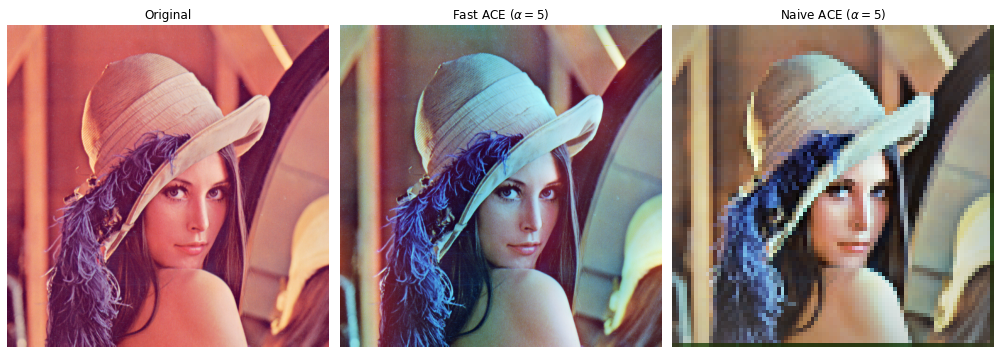

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].imshow(new_im)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(im_fast_ace)
ax[1].set_title(rf'Fast ACE ($\alpha={alpha}$)')
ax[1].axis('off')
ax[2].imshow(im_ace)
ax[2].set_title(rf'Naive ACE ($\alpha=5$)')
ax[2].axis('off')
plt.tight_layout()
plt.show()

---
## Fast computation using interpolation

Let's define the sum :

$$R(x,L)=\sum_{y\in\mathbb{T}^2}\omega(x-y)s_\alpha(L-I(y))$$

Compared to the first formula, $I(x)$ is replaced by a constant $L$.  
As $s_\alpha$ only depends now from $y$, this sum can be interpreted as a convolution.  
Hence it is possible to use the previous method for fast convolution computation

For ease of notation, we define :

$$s_\alpha^{(L)}(x)=s_\alpha(L-I(x))$$

In [14]:
def create_L_sequence(I: np.ndarray, J: int) ->np.ndarray:
    """
    Defines J values between which interpolation will be performed
    """
    return np.linspace(I.min(), I.max(), J)

def S_a_L(x: float or np.ndarray, L: float) ->callable:
    """
    Defines s_alpha^(L) as defined above
    """
    return S_a(L-x, alpha=8)

def compute_all_s_a_L(I: np.ndarray, N: int, L_seq:np.ndarray) -> np.ndarray:
    """
    Computes the values of s_alpha^(L) for each L_j in L_seq
    """
    J = len(L_seq)
    res = np.zeros((J, N, N))
    for j, L in enumerate(L_seq):
        res[j] = S_a_L(I, L)
    return res

def compute_all_R(I: np.ndarray, N:int, L_seq:np.ndarray):
    """Computes all R(x,L_j) terms
    """
    all_s_a = compute_all_s_a_L(I, N, L_seq)
    omega_im = np.zeros((N,)*2)
    res = np.zeros(all_s_a.shape)
    for i in range(N):
        for j in range(N):
            x = (i,j)
            omega_im[x] = omega(x, N)

    for j in range(all_s_a.shape[0]):
        res[j] = fast_convolution(omega_im, all_s_a[j])
    return res

def find_interval_index(x, seq):
    """
    Determines the index j such that seq[j] <= x <= seq[j+1]
    """
    index = 0
    for i in range(len(seq)-1):
        if seq[i] <= x <= seq[i+1]:
            index = i
            break
    return index
    
def interpol_R(I, N, J):
    """
    Performs interpolation to determine the approximate value of R(x)
    """
    R_vals = np.zeros((N,)*2)
    L_seq = create_L_sequence(I, J)
    all_R = compute_all_R(I, N, L_seq)
    for i in range(N):
        for j in range(N):
            x = (i,j)
            index = find_interval_index(I[x], L_seq)
            R_vals[x] = all_R[(index,)+x] + (I[x]-L_seq[index]) * (all_R[(index+1,)+x]-all_R[(index,)+x]) / (L_seq[index+1]-L_seq[index])
    return R_vals

def interpol_ACE(I, J):
    """
    Performs ACE on I using the interpolation approximation method
    """
    assert I.shape[0] == I.shape[1]
    N = I.shape[0]
    R_vals = interpol_R(I, N, J)
    return L(R_vals)

In [15]:
J = 8 # levels of interpolation
inter_r = interpol_ACE(i_r, J)
inter_g = interpol_ACE(i_g, J)
inter_b = interpol_ACE(i_b, J)
im_inter_ace = np.stack([inter_r, inter_g, inter_b]).transpose(1,2,0)

---
## Final results

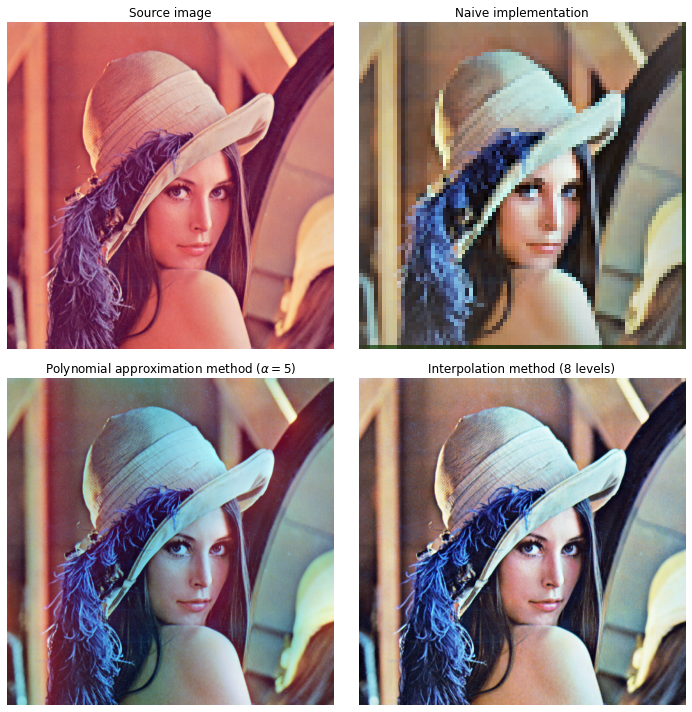

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
ax = axes.ravel()
ax[0].imshow(new_im)
ax[0].set_title('Source image')
ax[0].axis('off')

ax[1].imshow(im_ace)
ax[1].set_title('Naive implementation')
ax[1].axis('off')

ax[2].imshow(im_fast_ace)
ax[2].set_title(rf'Polynomial approximation method ($\alpha={alpha}$)')
ax[2].axis('off')

ax[3].imshow(im_inter_ace)
ax[3].set_title(rf'Interpolation method ({J} levels)')
ax[3].axis('off')
plt.tight_layout()
plt.show()